<a href="https://colab.research.google.com/github/Aras1703/Custom_model_CNN-ArasNet-/blob/main/Aras_Net_for_MNIST_Handwrite_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MNIST Handwrite Recognition**

in this case, i used a PyTorch library to take the MNIST dataset from "torchvision.dataset" function. To preprocessed the data i just normalizing the dataset and change it to Tensor from NumPy array. Then, i build my own model named Aras Net. Aras Net is a model that based on CNN, i use some function like Convolution, Pooling, and Padding from CNN. Furthermore, after the Convolution, Pooling, and Padding process i used a batch normalization function to normalizing the weighted in fully connected layer. Aras Net get 99,03 % accuracy in just 3 iteration. 

- Aras Net Explanation

First i used 7 x 7 kernel size to convolute the process 1 and then add a padding function so the pixels of the images wouldn't lose much an information. Second, i used 3 x 3 kernel size to convolute the process 2 and then add a padding function again, the reason i reduce the kernel size is to gain more information from the pixels. Third, after the convolution process i used a batch normalization and connect to hidden layer, i used a batch normalization to normalize a weighted value after the backpropagation process, so that my fully connected layer can be more faster and efficient for the training process.

##**Import Library**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

##**Define Number of Iteration for Training Loop, Learning Rate to Optimized the Algorithm, and Batch Size for Data Train and Test**

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1960
learning_rate = 0.001
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

##**Import and Normalize Data**

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/file/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/file/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1960, 1, 28, 28])

##**Plot the Original Data**

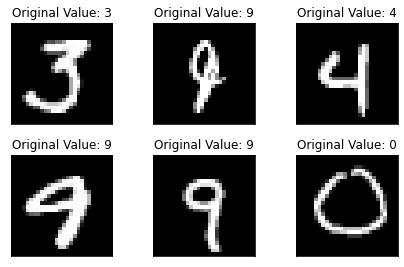

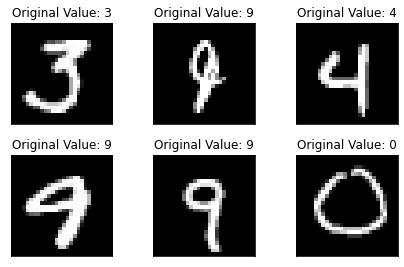

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Original Value: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

##**Build an Architecture named Aras Net**

In [ ]:
class ArasNet(nn.Module):
    def __init__(self):
        super(ArasNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, padding=3)    # original input 28 x 28, conv 22 x 22, padding 28 x 28, pooling 14 x 14
        self.bn1 = nn.BatchNorm2d(32)                              # normalizing weights
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=3)   # input 14 x 14, conv 12 x 12, padd 18 x 18, pooling 9 x 9
        self.bn2 = nn.BatchNorm2d(64)                              # normalizing weights
        self.fc1 = nn.Linear(5184, 128)                            # fully connected 5184 to 128 hidden layer
        self.fc2 = nn.Linear(128, 10)                              # fully connected 128 to output layer
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))       # add a pooling and relu function
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))       # add a pooling and relu function
        x = x.view(-1, 5184)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = ArasNet()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

##**Training Loop**

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

##**Test Loop**

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3125, Accuracy: 1045/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.341977
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.043977
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.678430
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.303289
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.257358
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.209567
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.269150
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.206516
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.244945
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.161999
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.262355
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.229904
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.226736
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.122423
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.035047
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.114040
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.096633
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.075337
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.062792
Train Epoch: 1 [12160

##**Plot Training and Test Loss**

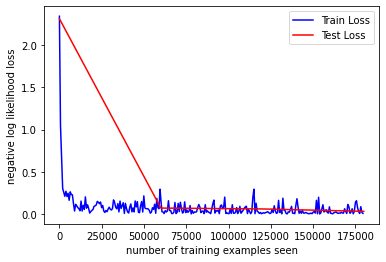

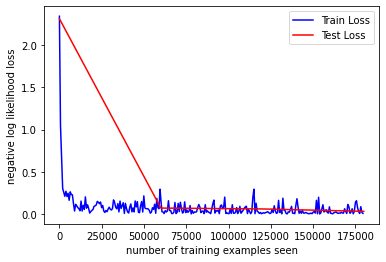

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

##**Plot a Predicted Data**

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


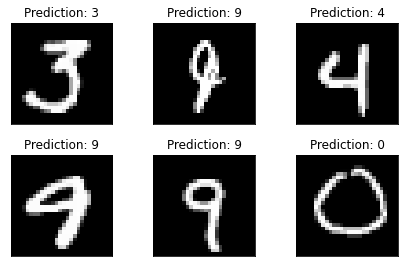

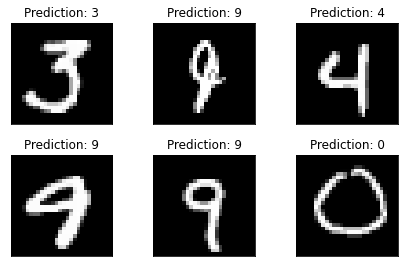

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig